In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [28]:
stock_samsung = pd.read_csv('Samsung_clean.csv')
stock_samsung

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/4/2010,16060,16180,16000,16180,11978.36523,11950800
1,1/5/2010,16520,16580,16300,16440,12170.84668,27925850
2,1/6/2010,16580,16820,16520,16820,12452.17090,22948850
3,1/7/2010,16820,16820,16260,16260,12037.59082,22107950
4,1/8/2010,16400,16420,16120,16420,12156.04102,14777550
...,...,...,...,...,...,...,...
3887,10/23/2025,96800,98500,96300,96500,96500.00000,18488581
3888,10/24/2025,97900,99000,97700,98800,98800.00000,18801925
3889,10/27/2025,101300,102000,100600,102000,102000.00000,22169970
3890,10/28/2025,100900,101000,99100,99500,99500.00000,20002282


In [29]:
stock_samsung['Date'] = pd.to_datetime(stock_samsung['Date'])
stock_samsung = stock_samsung.set_index(pd.DatetimeIndex(stock_samsung['Date'].values))
df_samsung = pd.DataFrame(stock_samsung, columns=['Close'])


In [30]:
scaler = MinMaxScaler(feature_range=(0,1))
df_samsung_scaled = scaler.fit_transform(np.array(df_samsung).reshape(-1,1))

In [31]:
train_size = int(len(df_samsung_scaled) * 0.7)
val_size = int(len(df_samsung_scaled) * 0.1)
test_size = len(df_samsung_scaled) - train_size - val_size

train_data = df_samsung_scaled[:train_size]
val_data = df_samsung_scaled[train_size:train_size+val_size]
test_data = df_samsung_scaled[train_size+val_size:]


In [32]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100

In [33]:
train_last_window = train_data[-time_step:]
val_data_extended = np.concatenate((train_last_window, val_data), axis=0)
val_last_window = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_window, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data_extended, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [34]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [35]:
from keras.layers import Input

model = Sequential()
# Dùng Input ở layer đầu tiên
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')


In [36]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,        # Số epoch bạn muốn train
    batch_size=32,    # batch size
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 6.8626e-04 - val_loss: 5.7681e-04
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 6.4504e-04 - val_loss: 8.6646e-04
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 6.4269e-04 - val_loss: 8.1008e-04
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 5.9711e-04 - val_loss: 6.6759e-04
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 5.3805e-04 - val_loss: 4.9756e-04
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 5.1734e-04 - val_loss: 9.8210e-04
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 5.1764e-04 - val_loss: 4.6792e-04
Epoch 9/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 5.0250e-04 - val_loss: 3.1557e-04
Epoch 10/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 4.4099e-04 - val_loss: 7.4149e-04
Epoch 11/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 4.6495e-04 - v

In [37]:
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [38]:
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)
print(f"Validation MAPE: {val_mape}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSLE: {val_msle}")

Validation MAPE: 0.017971995760377408
Validation RMSE: 0.01622807991139561
Validation MSLE: 9.286930785506168e-05


In [39]:
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
test_mse = mean_squared_error(y_pred_test, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred_test, y_test)
print(f"Test MAPE: {test_mape}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSLE: {test_msle}")

Test MAPE: 0.027239712384300237
Test RMSE: 0.021586813280181773
Test MSLE: 0.00017550995028682497


In [40]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input[0])
prediction_next30_days = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())


In [41]:
last_date = stock_samsung.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')


In [42]:
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data_inv = scaler.inverse_transform(train_data) 
val_data_inv = scaler.inverse_transform(val_data)
test_data_inv = scaler.inverse_transform(test_data)

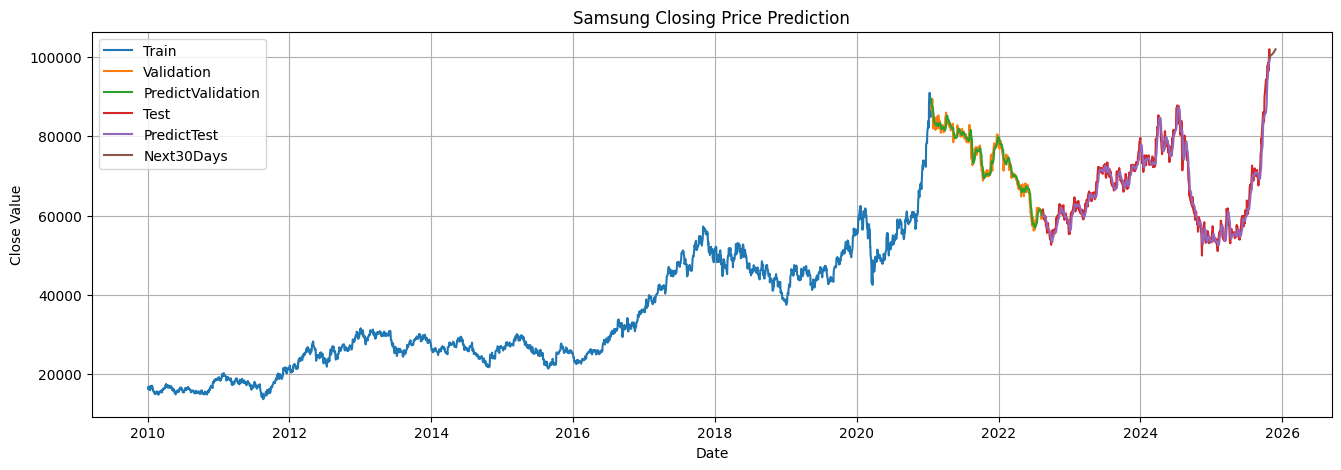

In [43]:
plt.figure(figsize=(16,5))
plt.plot(stock_samsung.index[:train_size], train_data_inv)
plt.plot(stock_samsung.index[train_size:train_size+val_size], val_data_inv)
plt.plot(stock_samsung.index[train_size:train_size+val_size], y_pred_val)
plt.plot(stock_samsung.index[train_size+val_size:], test_data_inv)
plt.plot(stock_samsung.index[train_size+val_size:], y_pred_test)
plt.plot(future_dates, prediction_next30_days)
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Samsung Closing Price Prediction')
plt.legend(['Train','Validation','PredictValidation','Test','PredictTest','Next30Days'])
plt.grid()
plt.show()